In [2]:
from functions.adjust_cases_functions import prepare_cases
from functions.general_utils import  get_bool
from models.seird_model import SEIRD

import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import numpy as np
import os

from global_config import config

import sys


poly_run  = 11001   #int(sys.argv[1])
name_dir  = 'bogota' #str(sys.argv[2])
drop_last_weeks = True #get_bool(sys.argv[3])

print("**** Running evaluation for hist. forecast for {}".format(name_dir))

data_dir            = config.get_property('data_dir_covid')
geo_dir             = config.get_property('geo_dir')
data_dir_mnps       = config.get_property('data_dir_col')
results_dir         = config.get_property('results_dir')
agglomerated_folder = os.path.join(data_dir, 'data_stages', 'colombia', 'agglomerated', 'geometry' )

polygons = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')
polygons = polygons.loc[poly_run]

data  =  pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates=['date_time'],
                    dayfirst=True).set_index('poly_id').loc[poly_run].set_index('date_time')

data  = data.resample('D').sum().fillna(0)[['num_cases','num_diseased']]
data  = prepare_cases(data, col='num_cases', cutoff=0)    # .rename({'smoothed_num_cases':'num_cases'})
data  = prepare_cases(data, col='num_diseased', cutoff=0) # .rename({'smoothed_num_cases':'num_cases'})
data  = data.rename(columns={'smoothed_num_cases': 'confirmed', 'smoothed_num_diseased':'death'})[['confirmed', 'death']]

print("**** **** Last day uploaded {}".format(pd.to_datetime(data.index.values[-1]).strftime('%Y-%b-%d')))

if drop_last_weeks:
    print("**** **** *** Droping last 2wk")
    data = data.iloc[:-14]

**** Running evaluation for hist. forecast for bogota
**** **** Last day uploaded 2021-May-08
**** **** *** Droping last 2wk


In [4]:
path_to_place = os.path.join(results_dir, 'weekly_forecast' , name_dir) #pd.to_datetime(data.index.values[-1]).strftime('%Y-%m-%d'))


In [22]:
dates_df = pd.DataFrame(data=os.listdir(path_to_place), columns=['date_frcst'])
dates_df = dates_df[dates_df['date_frcst'] != '.DS_Store']
dates_df["date_frcst"] = pd.to_datetime(dates_df["date_frcst"])
dates_df = dates_df.sort_values(by='date_frcst')
dates_df["path_to_frcst"] = dates_df["date_frcst"].map(lambda x: os.path.join(path_to_place, x.strftime('%Y-%m-%d') ) )


,date_frcst,path_to_frcst
11,2021-01-19,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
20,2021-01-23,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
10,2021-01-27,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
8,2021-01-29,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
14,2021-01-30,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
9,2021-02-07,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
0,2021-02-13,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
1,2021-02-14,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
12,2021-02-20,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...
13,2021-02-27,/Users/chaosdonkey06/Dropbox/BIOMAC/EAKF_Forec...


In [88]:
deaths_frcst_df = pd.read_csv(os.path.join(dates_df["path_to_frcst"].iloc[1], 'deaths_df.csv' ), parse_dates=["date"])
cases_frcst_df  = pd.read_csv(os.path.join(dates_df["path_to_frcst"].iloc[1], 'cases_df.csv' ), parse_dates=["date"])

deaths_frcst_df = deaths_frcst_df[deaths_frcst_df["type"]=='forecast']
cases_frcst_df = cases_frcst_df[cases_frcst_df["type"]=='forecast']

model = SEIRD(
    confirmed = data['confirmed'].cumsum(),
    death     = data['death'].cumsum(),
    T         = len(data),
    N         = int(polygons["attr_population"]),
    samples   = mcmc_samples
    )
    
def load_samples(filename):

    x = np.load(filename, allow_pickle=True)

    mcmc_samples = x['mcmc_samples'].item()
    post_pred_samples = x['post_pred_samples'].item()
    forecast_samples = x['forecast_samples'].item()

    return mcmc_samples, post_pred_samples, forecast_samples


In [171]:
def compute_evals(samples_d, samples_c, obs_d, obs_c):
    

    df_response_cases = pd.DataFrame(index=list(weekdict.keys()), columns=['crps', 'mae', 'rmse'])
    df_response_deaths = pd.DataFrame(index=list(weekdict.keys()), columns=['crps', 'mae', 'rmse'])
    weekdict = {'1w':6, '2w': 13, '3w': 20, '4w': 26}
    for kw in weekdict.keys():
        w = weekdict[kw]

        df_response_deaths['crps'].loc[kw] = eval_crps( samples_d[:,:w], obs_d[:w] )
        df_response_cases['crps'].loc[kw] = eval_crps( samples_c[:,:w], obs_c[:w] )
    

        df_response_deaths['mae'].loc[kw] = eval_mae( samples_d[:,:w], obs_d[:w] )
        df_response_cases['mae'].loc[kw] = eval_mae( samples_c[:,:w], obs_c[:w] )

        df_response_deaths['rmse'].loc[kw] = eval_rmse( samples_d[:,:w], obs_d[:w] )
        df_response_cases['rmse'].loc[kw] = eval_rmse( samples_c[:,:w], obs_c[:w] )

    df_response_cases["type"] = 'cases'
    df_response_deaths["type"] = 'deaths'

    return pd.concat([df_response_cases, df_response_deaths])

In [180]:
from pyro.contrib.forecast import eval_crps, eval_mae, eval_rmse

import torch
import tqdm

df_stats_all = []
for idx, row in dates_df.iterrows():
    date = row["date_frcst"].strftime('%Y-%m-%d')

    try:

        mcmc_samples, post_pred_samples, forecast_samples = load_samples(os.path.join(row["path_to_frcst"], 'samples.npz'  ))
        forecast_samples['mean_dz0'] = forecast_samples["dz0"]
        forecast_samples['mean_dy0'] = forecast_samples["dy0"]
        deaths_fitted = model.combine_samples(forecast_samples, f='mean_dz', use_future=True)
        cases_fitted  = model.combine_samples(forecast_samples, f='mean_dy', use_future=True)
        dates_frcst = deaths_frcst_df["date"]
        deaths_fore = deaths_fitted[:, deaths_frcst_df.index.values]
        cases_fore  = cases_fitted[:, cases_frcst_df.index.values]
        data_eval = data.loc[dates_frcst]

        death_samples = torch.tensor(np.array(deaths_fore)); deaths_obs = torch.tensor(list(data_eval["death"].values))
        cases_samples = torch.tensor(np.array(cases_fore));  cases_obs  = torch.tensor(list(data_eval["confirmed"].values))

        df_stats = compute_evals(death_samples, cases_samples, deaths_obs, cases_obs)
        df_stats["date_forecast"] = row["date_frcst"].strftime('%Y-%m-%d')
        df_stats_all.append(df_stats)
    except:
        print(f"Samples not found for date {date}")

df_stats_resume = pd.concat(df_stats_all)
df_stats_resume.index.name = 'week'


Samples not found for date 2021-01-29
Samples not found for date 2021-03-17
Samples not found for date 2021-04-18


In [198]:
df_stats_week_d

,crps,mae,rmse,type,date_forecast
week,,,,,
1w,58.88772,58.926592,59.820334,deaths,2021-01-19
1w,6.417973,8.810402,13.571386,deaths,2021-01-23
1w,4.167366,5.99573,7.332412,deaths,2021-01-27
1w,4.053315,5.659556,6.358855,deaths,2021-01-30
1w,4.809967,6.461102,7.203734,deaths,2021-02-07
1w,3.38032,4.670364,5.314916,deaths,2021-02-13
1w,3.252288,4.595911,5.193891,deaths,2021-02-14
1w,2.751105,4.006646,4.467311,deaths,2021-02-20
1w,2.808655,4.084675,4.540887,deaths,2021-02-27


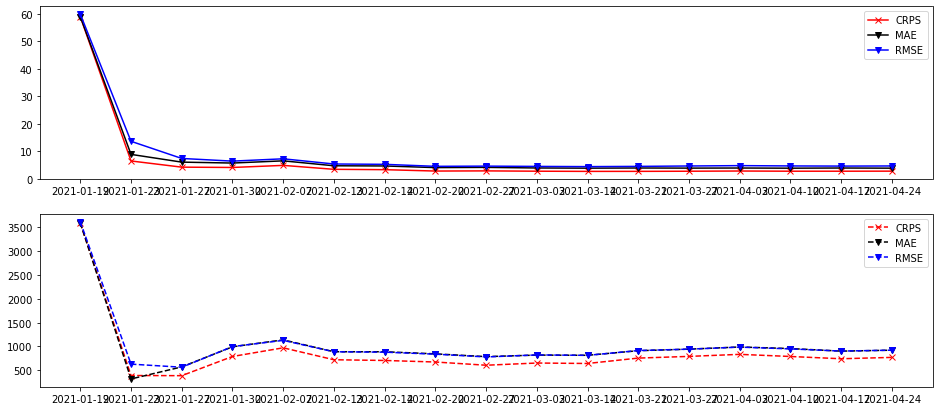

In [200]:
kw='1w'
df_stats_week = df_stats_resume.loc[kw]
df_stats_week_d = df_stats_week[df_stats_week["type"]=='deaths']
df_stats_week_c = df_stats_week[df_stats_week["type"]=='cases']

df_stats_week_d

fig, axes = plt.subplots(2, 1, figsize=(16, 7)) #, sharex=True)

axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["crps"], color='r', marker='x', label='CRPS')
axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["mae"], color='k', marker='v', label='MAE')
axes[0].plot(df_stats_week_d["date_forecast"], df_stats_week_d["rmse"], color='b', marker='v', label='RMSE')

axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["crps"], color='r', marker='x', label='CRPS', linestyle='--')
axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["mae"], color='k', marker='v', label='MAE', linestyle='--')
axes[1].plot(df_stats_week_c["date_forecast"], df_stats_week_c["rmse"], color='b', marker='v', label='RMSE', linestyle='--')

axes[0].legend()
axes[1].legend()

In [185]:
df_stats_resume

weekdict = {'1w':6, '2w': 13, '3w': 20, '4w': 26}
for kw in weekdict.keys():
    df_stats_week = df_stats_resume.loc[kw]

,crps,mae,rmse,type,date_forecast
week,,,,,
1w,3592.472333,3592.414429,3618.431469,cases,2021-01-19
2w,2794.771769,2794.741588,2913.846426,cases,2021-01-19
3w,2296.146783,2296.126199,2485.399685,cases,2021-01-19
4w,2019.239978,2019.233923,2242.607028,cases,2021-01-19
1w,58.88772,58.926592,59.820334,deaths,2021-01-19
...,...,...,...,...,...
4w,283.028797,362.839203,488.920229,cases,2021-04-24
1w,2.714739,3.798726,4.600834,deaths,2021-04-24
2w,3.852357,5.009215,5.915744,deaths,2021-04-24


In [170]:
df_stats_ = pd.concat(df_stats_all)

,crps,mae,rmse,type
1w,391.087166,319.051921,629.760226,cases
2w,599.256637,599.917912,2102.218102,cases
3w,804.47481,787.078955,3717.039766,cases
4w,964.251628,841.286311,5359.268811,cases
1w,6.417973,8.810402,13.571386,deaths
2w,12.402773,17.202606,28.156882,deaths
3w,14.848721,19.967548,43.537486,deaths
4w,16.880891,21.290828,62.677093,deaths
